In [1]:
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from pmdarima import auto_arima

In [2]:
# Evitar warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Cargar el dataset
df = pd.read_csv("processed\data_processed_final.csv")

In [72]:
def calculate_change_indices(df):
    change_indices = []
    for i in range(1, len(df)):
        if df.iloc[i]['last_performance'] != df.iloc[i-1]['last_performance']:
            change_indices.append(i)
    return change_indices


def plot_results(y, df_jugador, df_predictions, prediction_index):
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_jugador['Fecha'], df_jugador[y], label='Real', color='blue')
    plt.plot(df_predictions[df_predictions['Predicciones'].notnull()]['Fecha'], df_predictions[df_predictions['Predicciones'].notnull()]['Predicciones'], label='Predicción', color='red')
    plt.scatter(df_jugador.iloc[prediction_index]['Fecha'], df_jugador.iloc[prediction_index][y], color='green', label='Día antes de predicción')
    plt.title(f'Predicción de {y} para el jugador {jugador}')
    plt.xlabel('Fecha')
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)

    # Configurar el eje X para mostrar solo el nombre del mes
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Un mes por etiqueta
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Mostrar solo el nombre del mes (Ene, Feb, etc.)

    # Rotar las etiquetas del eje X para mayor legibilidad
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def calculate_errors(df_jugador, df_predictions, y):
    aux = df_predictions[df_predictions['Predicciones'].notnull()]
    aux['Diferencia'] = abs(aux[y] - aux['Predicciones'])

    mean_error_todos = np.mean(aux['Diferencia'])
    std_error_todos = np.std(aux['Diferencia'])
    min_error_todos = np.min(aux['Diferencia'])
    max_error_todos = np.max(aux['Diferencia'])
    median_todos = np.median(aux['Diferencia'])

    change_indices = calculate_change_indices(df_jugador)

    match_days = df_jugador.iloc[np.array(change_indices)]['Fecha']
    errors_match_days = aux[aux['Fecha'].isin(match_days)]['Diferencia']

    mean_error_dia_partido = np.mean(errors_match_days)
    std_error_dia_partido = np.std(errors_match_days)
    min_error_dia_partido = np.min(errors_match_days)
    max_error_dia_partido = np.max(errors_match_days)
    median_dia_partido = np.median(errors_match_days)


    before_match_days = df_jugador.iloc[np.array(change_indices) - 1]['Fecha']
    errors_before_match_days = aux[aux['Fecha'].isin(before_match_days)]['Diferencia']

    mean_error_dia_antes_partido = np.mean(errors_before_match_days)
    std_error_dia_antes_partido = np.std(errors_before_match_days)
    min_error_dia_antes_partido = np.min(errors_before_match_days)
    max_error_dia_antes_partido = np.max(errors_before_match_days)
    median_dia_antes_partido = np.median(errors_before_match_days)

    print("______Todos los días____________")
    print(f"Mean error todos: {mean_error_todos}")
    print(f"Std error todos: {std_error_todos}")
    print(f"Min error todos: {min_error_todos}")
    print(f"Max error todos: {max_error_todos}")
    print(f"Median error todos: {median_todos}\n")

    print("______Días de partido___________")
    print(f"Mean error dia partido: {mean_error_dia_partido}")
    print(f"Std error dia partido: {std_error_dia_partido}")
    print(f"Min error dia partido: {min_error_dia_partido}")
    print(f"Max error dia partido: {max_error_dia_partido}")
    print(f"Median error dia partido: {median_dia_partido}\n")

    print("______Días antes de partido_____")
    print(f"Mean error dia antes partido: {mean_error_dia_antes_partido}")
    print(f"Std error dia antes partido: {std_error_dia_antes_partido}")
    print(f"Min error dia antes partido: {min_error_dia_antes_partido}")
    print(f"Max error dia antes partido: {max_error_dia_antes_partido}")
    print(f"Median error dia antes partido: {median_dia_antes_partido}")

In [71]:
def evaluate_model(df_jugador, config):
    '''
    Evaluar el modelo para un jugador con la configuración dada

    Parámetros:
    - df_jugador: DataFrame con los datos del jugador
    - config: Diccionario con la configuración del modelo
        - order: (p,d,q) del modelo SARIMA
        - seasonal_order: (P,D,Q,s) del modelo SARIMA
        - y: Serie a predecir
        - exog: Serie exógena
        - pred_options: Opciones de predicción: 
            - 'matches': Predice los días de partido
            - 'one': Predice a partir de un día hasta el final
            - 'step': Predice cada n días
        - step_options: Si pred_options es 'matches', opciones de predicción:
            - 'next_match': Predice los días hasta el siguiente partido
            - 'next_day': Predice solo un día (el del partido)
        - train_size: Si pred_options es 'one', porcentaje de datos a partir del cual se empieza a predecir
        - step: Si pred_options es 'step', cada cuántos días se predice y número de días a predecir

    Devuelve:
    - df_predictions: DataFrame con las predicciones
    '''

    order = config['order']
    seasonal_order = config['seasonal_order']
    y = config['y']
    exog = config['exog']
    
    
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    
    if config['pred_options'] == 'matches':
        match_indices = calculate_change_indices(df_jugador)

        for i in range(len(match_indices)-1):
            matchday = match_indices[i]
            next_matchday = match_indices[i+1]

            train_data = df_jugador.iloc[:matchday]
            test_data = df_jugador.iloc[matchday:]
            
            days_to_next_match = next_matchday - matchday
            
            modelo = SARIMAX(train_data[y], 
                                exog=train_data[exog],
                                order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()
            
            if config['step_options'] == 'next_match':
                predicciones = resultado.predict(start=matchday, end=next_matchday-1,
                                                exog=test_data[exog][:days_to_next_match], dynamic=False)
                
                df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones

            elif config['step_options'] == 'next_day':
                # Solo se predice un día
                predicciones = resultado.predict(start=matchday, end=matchday,
                                                exog=test_data[exog][:1], dynamic=False)
            
                df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

        
        if config['step_options'] == 'next_day':        
            # Rellenar los valores nulos con el último valor conocido
            df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
        
        prediction_index = np.array(match_indices) - 1


    elif config['pred_options'] == 'one':
        i = int(len(df_jugador)*config['train_size'])
        train_data = df_jugador[:i]
        test_data = df_jugador[i:]  

        modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order, exog=train_data[exog])

        resultado = modelo.fit()

        predicciones = resultado.predict(start=i, end=len(df_jugador)-1, exog=test_data[exog], dynamic=False)

        df_predictions.iloc[i:, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = i -1
    
    elif config['pred_options'] == 'step':
        step = config['step']
        
        for i in range(2, len(df_jugador)-step+1, step):
            train_data = df_jugador[:i]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order, exog=train_data[exog])

            resultado = modelo.fit()

            predicciones = resultado.forecast(steps=step, exog=df_jugador[exog][i:i+step])
            
            df_predictions.iloc[i:i+step, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = np.arange(2, len(df_jugador)-step+1, step) -1
        
    plot_results(y, df_jugador, df_predictions, prediction_index)
    calculate_errors(df_jugador, df_predictions, y)

    return df_predictions


def evaluate_model_no_exog(df_jugador, config):
    
    order = config['order']
    seasonal_order = config['seasonal_order']
    y = config['y']
    
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    
    if config['pred_options'] == 'matches':
        match_indices = calculate_change_indices(df_jugador)

        for i in range(len(match_indices)-1):
            matchday = match_indices[i]
            next_matchday = match_indices[i+1]

            train_data = df_jugador.iloc[:matchday]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()
            
            if config['step_options'] == 'next_match':
                predicciones = resultado.predict(start=matchday, end=next_matchday-1, dynamic=False)
                
                df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones

            elif config['step_options'] == 'next_day':
                # Solo se predice un día
                predicciones = resultado.predict(start=matchday, end=matchday, dynamic=False)
            
                df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

        
        if config['step_options'] == 'next_day':        
            # Rellenar los valores nulos con el último valor conocido
            df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
        
        prediction_index = np.array(match_indices) - 1


    elif config['pred_options'] == 'one':
        i = int(len(df_jugador)*config['train_size'])
        train_data = df_jugador[:i]
        test_data = df_jugador[i:]  

        modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

        resultado = modelo.fit()

        predicciones = resultado.predict(start=i, end=len(df_jugador)-1, dynamic=False)

        df_predictions.iloc[i:, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = i -1
    
    elif config['pred_options'] == 'step':
        step = config['step']
        
        for i in range(2, len(df_jugador)-step+1, step):
            train_data = df_jugador[:i]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()

            predicciones = resultado.forecast(steps=step)
            
            df_predictions.iloc[i:i+step, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = np.arange(2, len(df_jugador)-step+1, step) -1
        
    plot_results(y, df_jugador, df_predictions, prediction_index)
    calculate_errors(df_jugador, df_predictions, y)

    return df_predictions

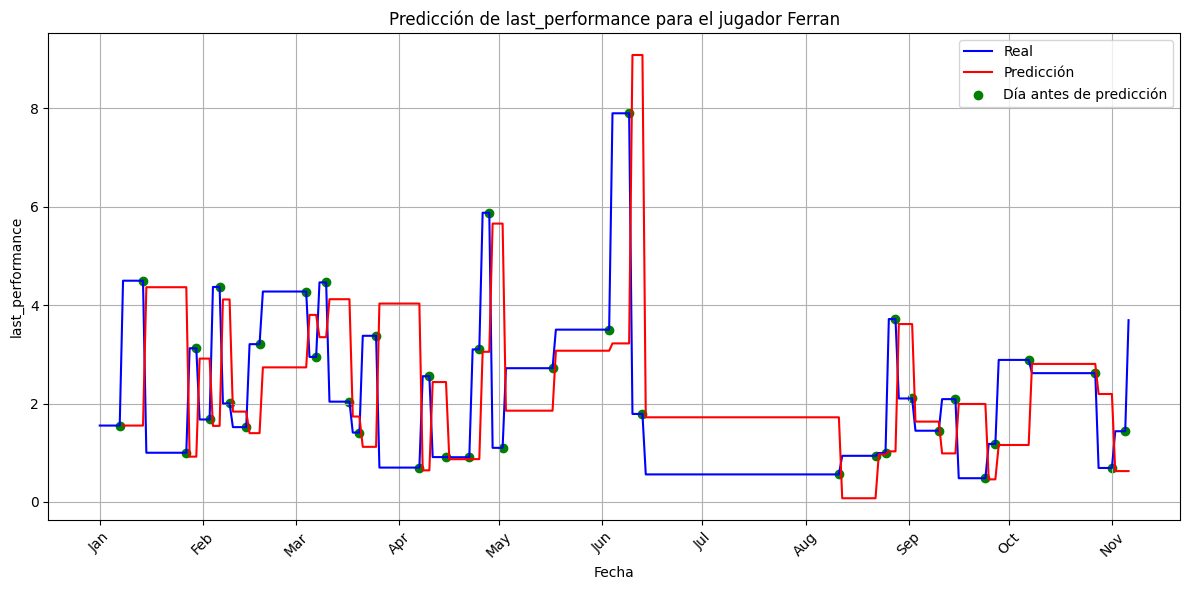

______Todos los días____________
Mean error todos: 1.5601577177197448
Std error todos: 1.2670698773199234
Min error todos: 0.027849272356565424
Max error todos: 7.291117042951431
Median error todos: 1.1599525860070874

______Días de partido___________
Mean error dia partido: 1.8385306823343843
Std error dia partido: 1.4488426914510888
Min error dia partido: 0.027849272356565424
Max error dia partido: 7.291117042951431
Median error dia partido: 1.52420786859489

______Días antes de partido_____
Mean error dia antes partido: 1.8062316445047595
Std error dia antes partido: 1.4538569119161677
Min error dia antes partido: 0.027849272356565424
Max error dia antes partido: 7.291117042951431
Median error dia antes partido: 1.5179997058040837


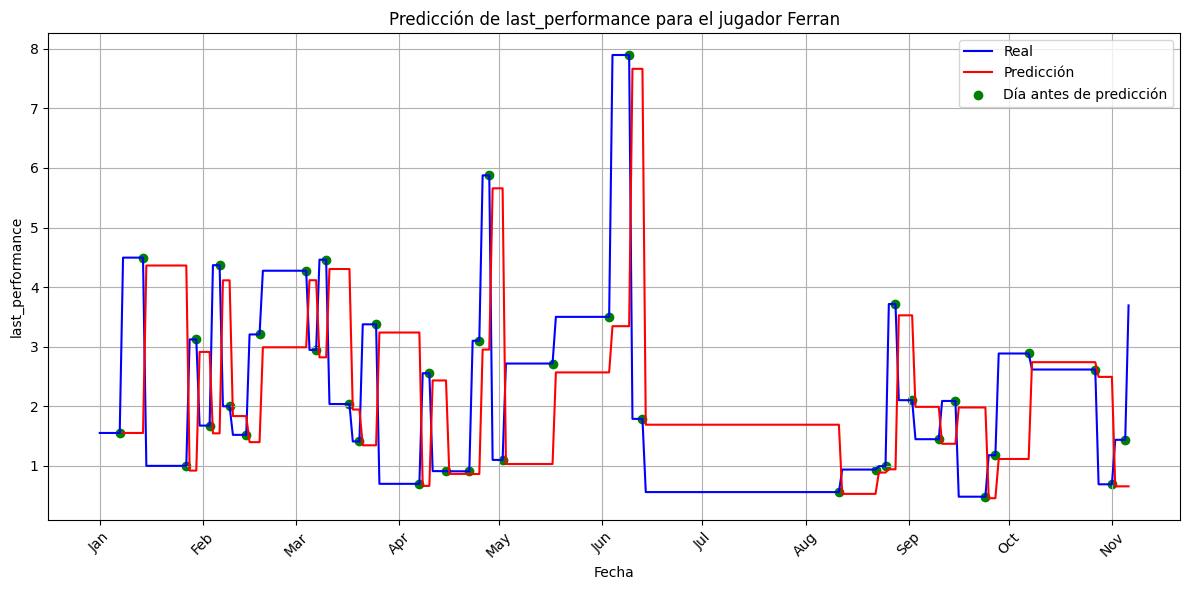

______Todos los días____________
Mean error todos: 1.5565997193875778
Std error todos: 1.125762149119646
Min error todos: 0.044080811387619434
Max error todos: 5.87479870966386
Median error todos: 1.236675660061736

______Días de partido___________
Mean error dia partido: 1.828800726374752
Std error dia partido: 1.2763875261086288
Min error dia partido: 0.044080811387619434
Max error dia partido: 5.87479870966386
Median error dia partido: 1.6862628106300395

______Días antes de partido_____
Mean error dia antes partido: 1.7970181938018606
Std error dia antes partido: 1.2777491292676761
Min error dia antes partido: 0.044080811387619434
Max error dia antes partido: 5.87479870966386
Median error dia antes partido: 1.6627272060956089


In [75]:
jugador = 'Ferran'
df_jugador = df[df['Player'] == jugador]
config = {
    'order': (1,0,0),
    'seasonal_order': (0,0,0,0),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

df_predictions = evaluate_model(df_jugador, config)
df_predictions2 = evaluate_model_no_exog(df_jugador, config)

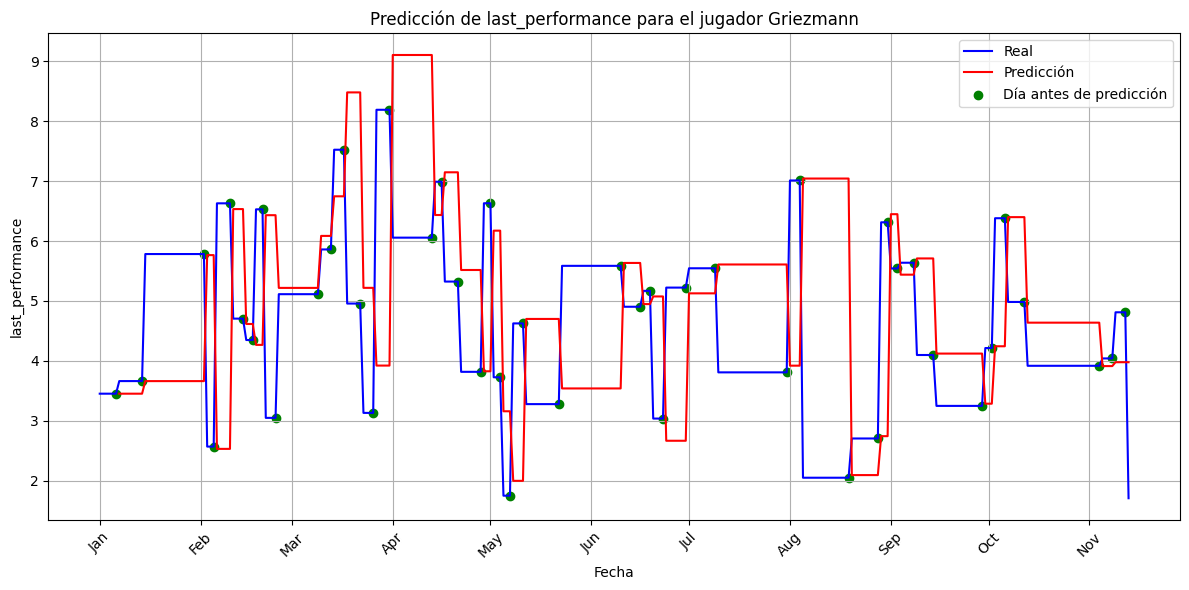

______Todos los días____________
Mean error todos: 1.7615098371373819
Std error todos: 1.2629743639354587
Min error todos: 0.1049191451320084
Max error todos: 4.997128430486594
Median error todos: 1.8018246990635784

______Días de partido___________
Mean error dia partido: 1.7855365271700916
Std error dia partido: 1.2394301702581059
Min error dia partido: 0.1049191451320084
Max error dia partido: 4.997128430486594
Median error dia partido: 1.8018246990635784

______Días antes de partido_____
Mean error dia antes partido: 1.7744807135983636
Std error dia antes partido: 1.2512394237622289
Min error dia antes partido: 0.1049191451320084
Max error dia antes partido: 4.997128430486594
Median error dia antes partido: 1.7513833210286305


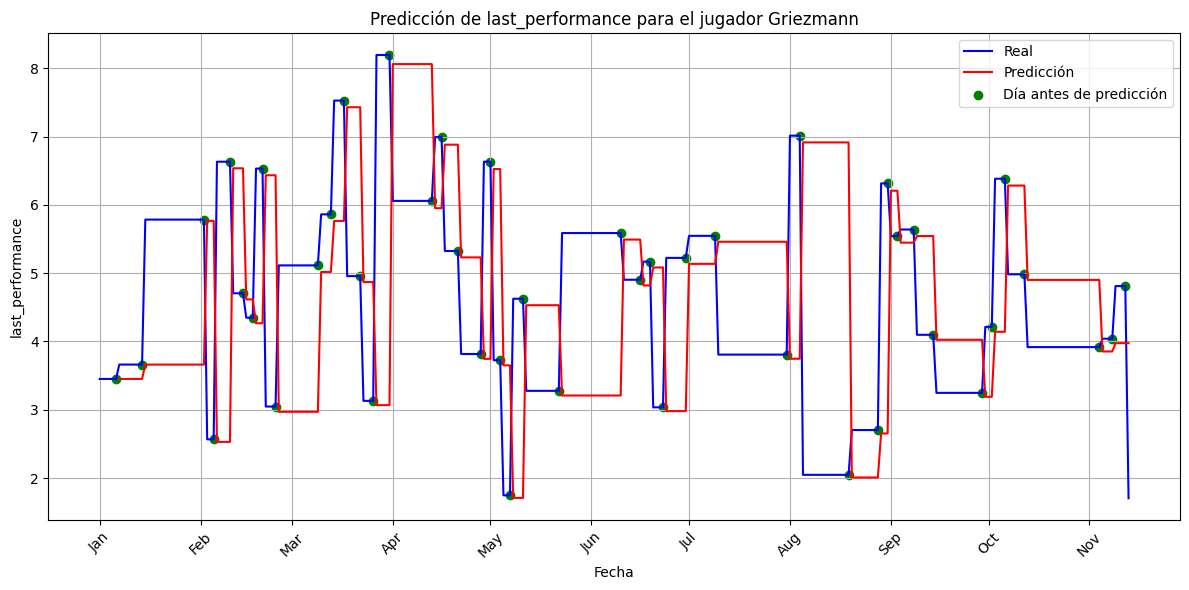

______Todos los días____________
Mean error todos: 1.8259668399005915
Std error todos: 1.178888625570549
Min error todos: 0.18644769413565143
Max error todos: 5.125311343779395
Median error todos: 1.6518049181351628

______Días de partido___________
Mean error dia partido: 1.8511740068095928
Std error dia partido: 1.200107302766647
Min error dia partido: 0.18644769413565143
Max error dia partido: 5.125311343779395
Median error dia partido: 1.7616262867842956

______Días antes de partido_____
Mean error dia antes partido: 1.8416460586807681
Std error dia antes partido: 1.2119841101356974
Min error dia antes partido: 0.18644769413565143
Max error dia antes partido: 5.125311343779395
Median error dia antes partido: 1.7502507080916805


In [76]:
jugador = 'Griezmann'
df_jugador = df[df['Player'] == jugador]
config = {
    'order': (1,0,0),
    'seasonal_order': (0,0,0,0),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

df_predictions = evaluate_model(df_jugador, config)
df_predictions2 = evaluate_model_no_exog(df_jugador, config)

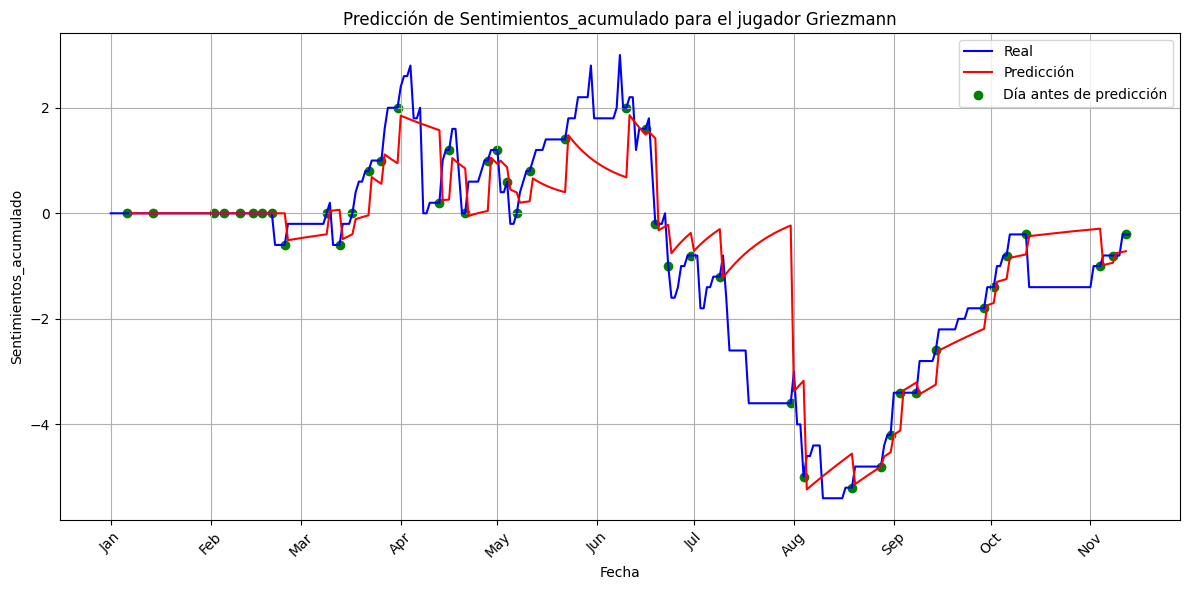

______Todos los días____________
Mean error todos: 0.658522133424583
Std error todos: 0.6948745235112632
Min error todos: 8.797410913302302e-07
Max error todos: 3.368292061545355
Median error todos: 0.499992873075226

______Días de partido___________
Mean error dia partido: 0.3447820954412141
Std error dia partido: 0.2576547337240082
Min error dia partido: 8.797410913302302e-07
Max error dia partido: 0.9668223635548301
Median error dia partido: 0.3255091101455857

______Días antes de partido_____
Mean error dia antes partido: 0.6042249356566902
Std error dia antes partido: 0.6116650777202151
Min error dia antes partido: 8.79741091333072e-07
Max error dia antes partido: 3.368292061545355
Median error dia antes partido: 0.43471791133697024


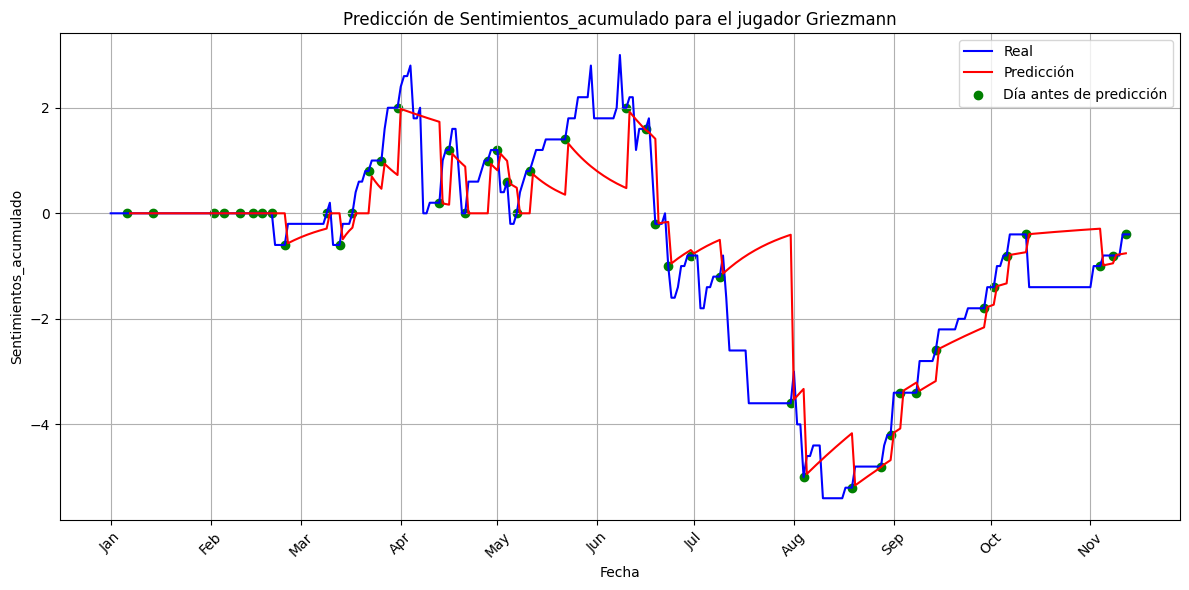

______Todos los días____________
Mean error todos: 0.6652579177482961
Std error todos: 0.6913905265818459
Min error todos: 0.0
Max error todos: 3.193211136361586
Median error todos: 0.5046484970597467

______Días de partido___________
Mean error dia partido: 0.3469080996048763
Std error dia partido: 0.25754485224092843
Min error dia partido: 0.0
Max error dia partido: 1.0054580633890478
Median error dia partido: 0.3570924035526013

______Días antes de partido_____
Mean error dia antes partido: 0.621237086121183
Std error dia antes partido: 0.6112248527633255
Min error dia antes partido: 0.0
Max error dia antes partido: 3.193211136361586
Median error dia antes partido: 0.5057892219178577


In [77]:
config = {
    'order': (1,0,0),
    'seasonal_order': (0,0,0,0),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

df_predictions = evaluate_model(df_jugador, config)
df_predictions2 = evaluate_model_no_exog(df_jugador, config)

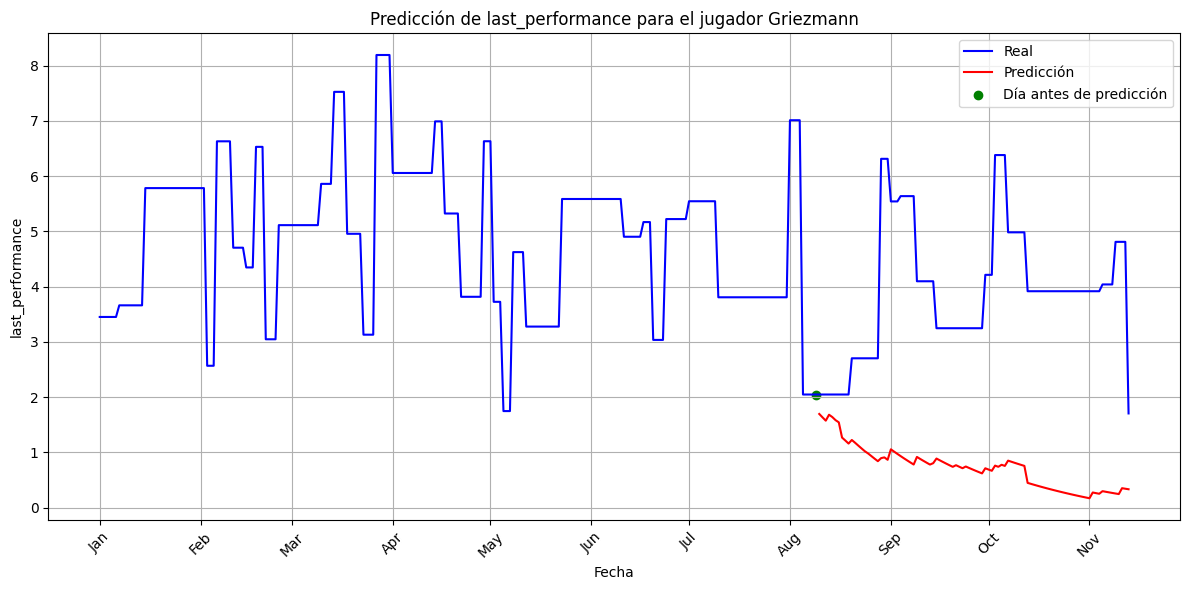

______Todos los días____________
Mean error todos: 3.2010293655925444
Std error todos: 1.3585859654735923
Min error todos: 0.3520780552446712
Max error todos: 5.642837767622434
Median error todos: 3.5419722586244466

______Días de partido___________
Mean error dia partido: 3.6939799008073275
Std error dia partido: 1.2922807316295852
Min error dia partido: 1.372209080769442
Max error dia partido: 5.6212703587694675
Median error dia partido: 3.7421428471056166

______Días antes de partido_____
Mean error dia antes partido: 3.758183879869227
Std error dia antes partido: 1.3103806014242678
Min error dia antes partido: 0.8879251001838733
Max error dia antes partido: 5.626726534102712
Median error dia antes partido: 3.7741027587002147


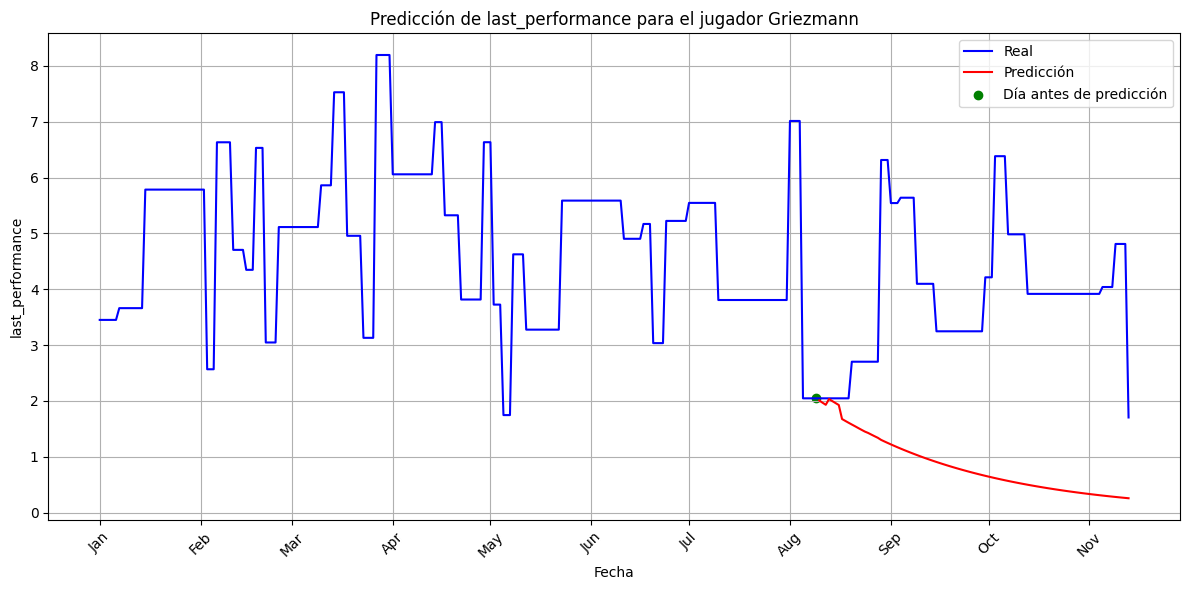

______Todos los días____________
Mean error todos: 3.076278169662576
Std error todos: 1.4662520567914563
Min error todos: 0.012946150118969602
Max error todos: 5.800564227886924
Median error todos: 3.480781611109857

______Días de partido___________
Mean error dia partido: 3.6308992001363163
Std error dia partido: 1.30645211755146
Min error dia partido: 1.1241587931476782
Max error dia partido: 5.7622911875667375
Median error dia partido: 3.732777325961627

______Días antes de partido_____
Mean error dia antes partido: 3.639519614765209
Std error dia antes partido: 1.4266726732521582
Min error dia antes partido: 0.436759803576257
Max error dia antes partido: 5.800564227886924
Median error dia antes partido: 3.751759269356496


In [78]:
jugador = 'Griezmann'
df_jugador = df[df['Player'] == jugador]
config = {
    'order': (1,0,1),
    'seasonal_order': (1,0,0,12),
    'exog': 'Sentimientos_acumulado',
    'y': 'last_performance',
    'pred_options': 'one',
    'train_size': 0.7,
}

df_predictions = evaluate_model(df_jugador, config)
df_predictions = evaluate_model_no_exog(df_jugador, config)

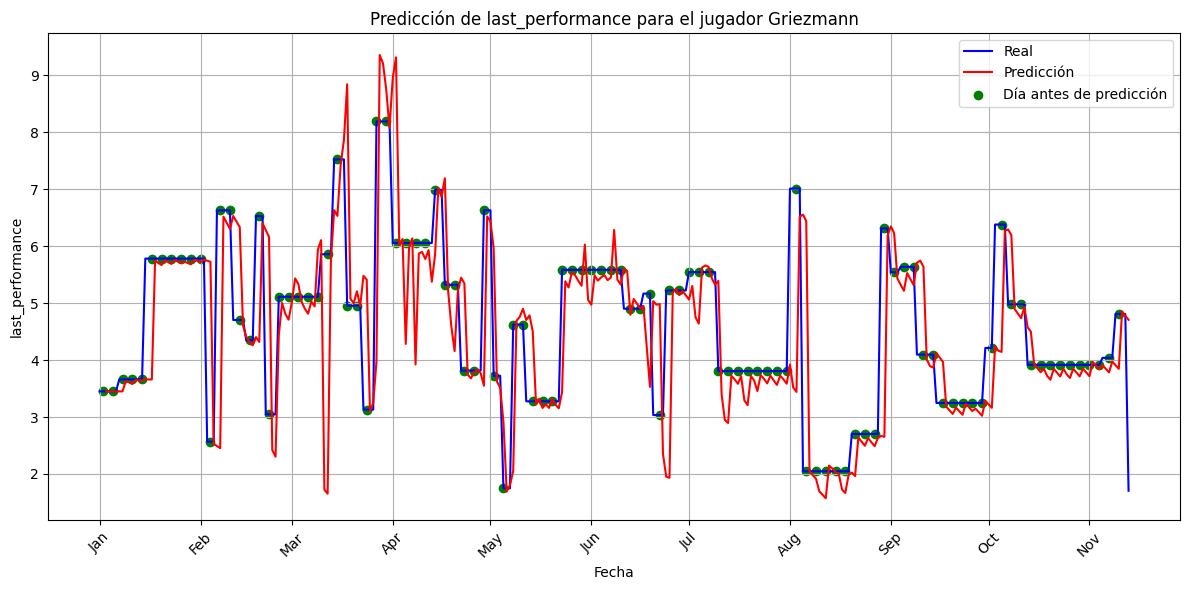

______Todos los días____________
Mean error todos: 0.6624417099901894
Std error todos: 1.0106457945228071
Min error todos: 2.6357034852431127e-06
Max error todos: 4.508671397769215
Median error todos: 0.19023141802722243

______Días de partido___________
Mean error dia partido: 1.8267778072734997
Std error dia partido: 1.227858377775503
Min error dia partido: 0.06051697980769433
Max error dia partido: 4.508671397769215
Median error dia partido: 1.6322456010890107

______Días antes de partido_____
Mean error dia antes partido: 0.24243956184425386
Std error dia antes partido: 0.31625709046500333
Min error dia antes partido: 2.6357034852431127e-06
Max error dia antes partido: 1.6392158748726562
Median error dia antes partido: 0.11614611872285652


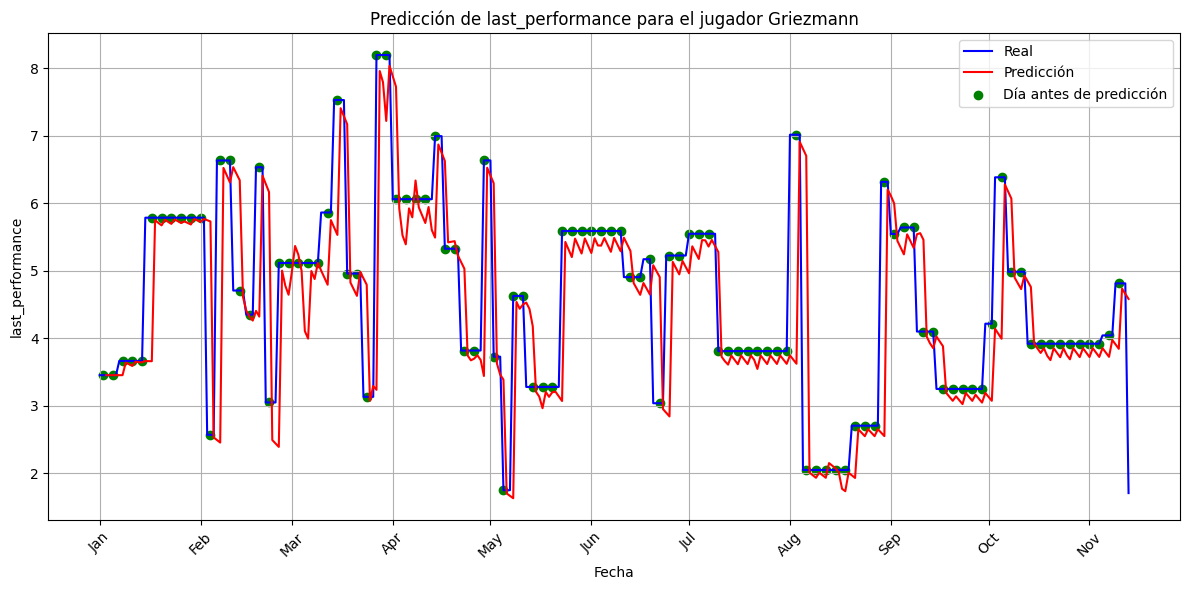

______Todos los días____________
Mean error todos: 0.6032934996906908
Std error todos: 0.9480130079420273
Min error todos: 4.271634121977286e-07
Max error todos: 4.958548000741822
Median error todos: 0.1772939009427521

______Días de partido___________
Mean error dia partido: 1.85893179576679
Std error dia partido: 1.2014947690169198
Min error dia partido: 0.06054096781469287
Max error dia partido: 4.958548000741822
Median error dia partido: 1.7545846448264357

______Días antes de partido_____
Mean error dia antes partido: 0.18678626990783664
Std error dia antes partido: 0.19337840034446568
Min error dia antes partido: 4.271634121977286e-07
Max error dia antes partido: 1.1418835633157864
Median error dia antes partido: 0.13959239135525614


In [79]:
config = {
    'order': (1,0,1),
    'seasonal_order': (1,0,0,12),
    'exog': 'Sentimientos_acumulado',
    'y': 'last_performance',
    'pred_options': 'step',
    'step': 3
}

df_predictions = evaluate_model(df_jugador, config)
df_predictions = evaluate_model_no_exog(df_jugador, config)